In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_id = "meta-llama/Meta-Llama-3.1-8B"
peft_model_id = "/home/ljc/representation-engineering/llama-recipes/model-ap"

model = AutoModelForCausalLM.from_pretrained(model_id)
model.eval()
tokenizer=AutoTokenizer.from_pretrained(model_id)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [1]:
model

NameError: name 'model' is not defined

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


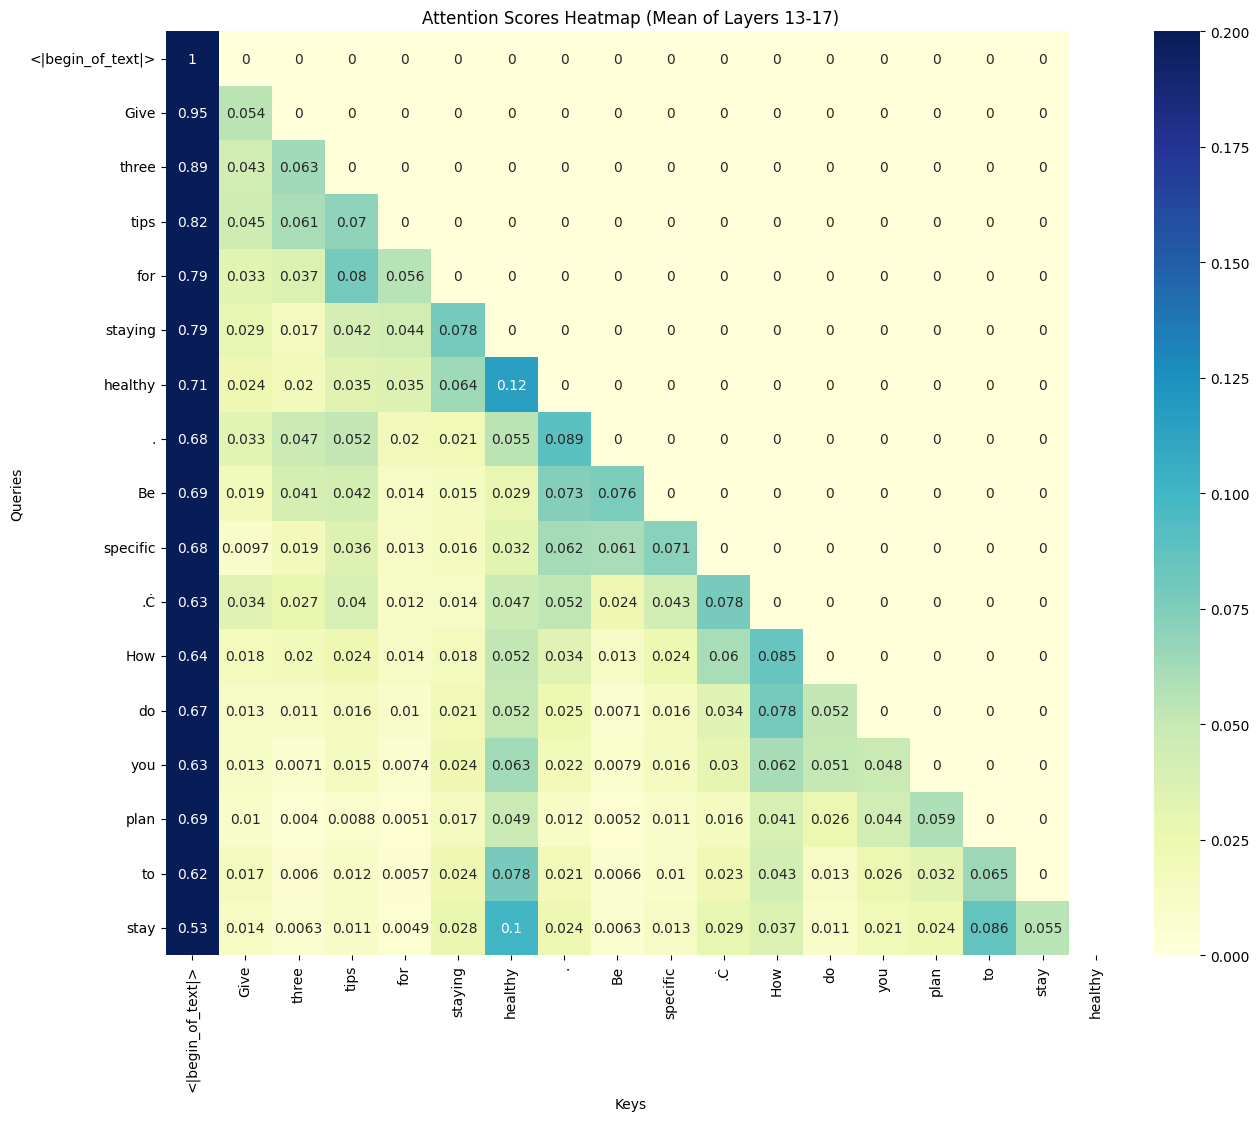

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import seaborn as sns
# 输入文本
input_text = "Give three tips for staying healthy."

# 将输入文本编码为 token
inputs = tokenizer(input_text, return_tensors="pt")

# 生成新 token
generate_output = model.generate(inputs['input_ids'], max_length=inputs['input_ids'].shape[1] + 10, output_attentions=True, return_dict_in_generate=True)

# 获取生成的所有 token 的注意力值
attentions = generate_output.attentions  # 这是一个包含所有生成步骤的注意力值的元组
generated_ids = generate_output.sequences[0]  # 获取生成的 token 序列

# 获取所有 token 标签
tokens = tokenizer.convert_ids_to_tokens(generated_ids)
tokens = [token.replace('Ġ', '') for token in tokens]

# 选择第 13 到第 17 层的索引
selected_layers = range(13, 17)  # Python 索引从 0 开始，第 13 层索引为 12，第 17 层索引为 16

# 初始化一个矩阵来存储所选层的注意力值的均值
all_attention = []
max_seq_length = max([step[0][0][0].shape[-1] for step in attentions])

for step in attentions:
    layer_attention = []
    for layer_index in selected_layers:
        attn = step[layer_index][0].detach().cpu().numpy()  # 形状 (num_heads, sequence_length, sequence_length)
        attn = attn.mean(axis=0)  # 对所有注意力头取均值，形状 (sequence_length, sequence_length)
        pad_width = max_seq_length - attn.shape[-1]
        if pad_width > 0:
            attn = np.pad(attn, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
        layer_attention.append(attn)
    # 对所选层的注意力值取均值
    mean_layer_attention = np.mean(layer_attention, axis=0)
    all_attention.append(mean_layer_attention)

# 将注意力值拼接成一个完整的矩阵
complete_attention = np.concatenate(all_attention, axis=0)

# 创建热力图
plt.figure(figsize=(15, 12))
sns.heatmap(complete_attention, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens[:complete_attention.shape[0]], vmin=0, vmax=0.2)
plt.title('Attention Scores Heatmap (Mean of Layers 13-17)')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()


In [5]:
model.load_adapter(peft_model_id)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


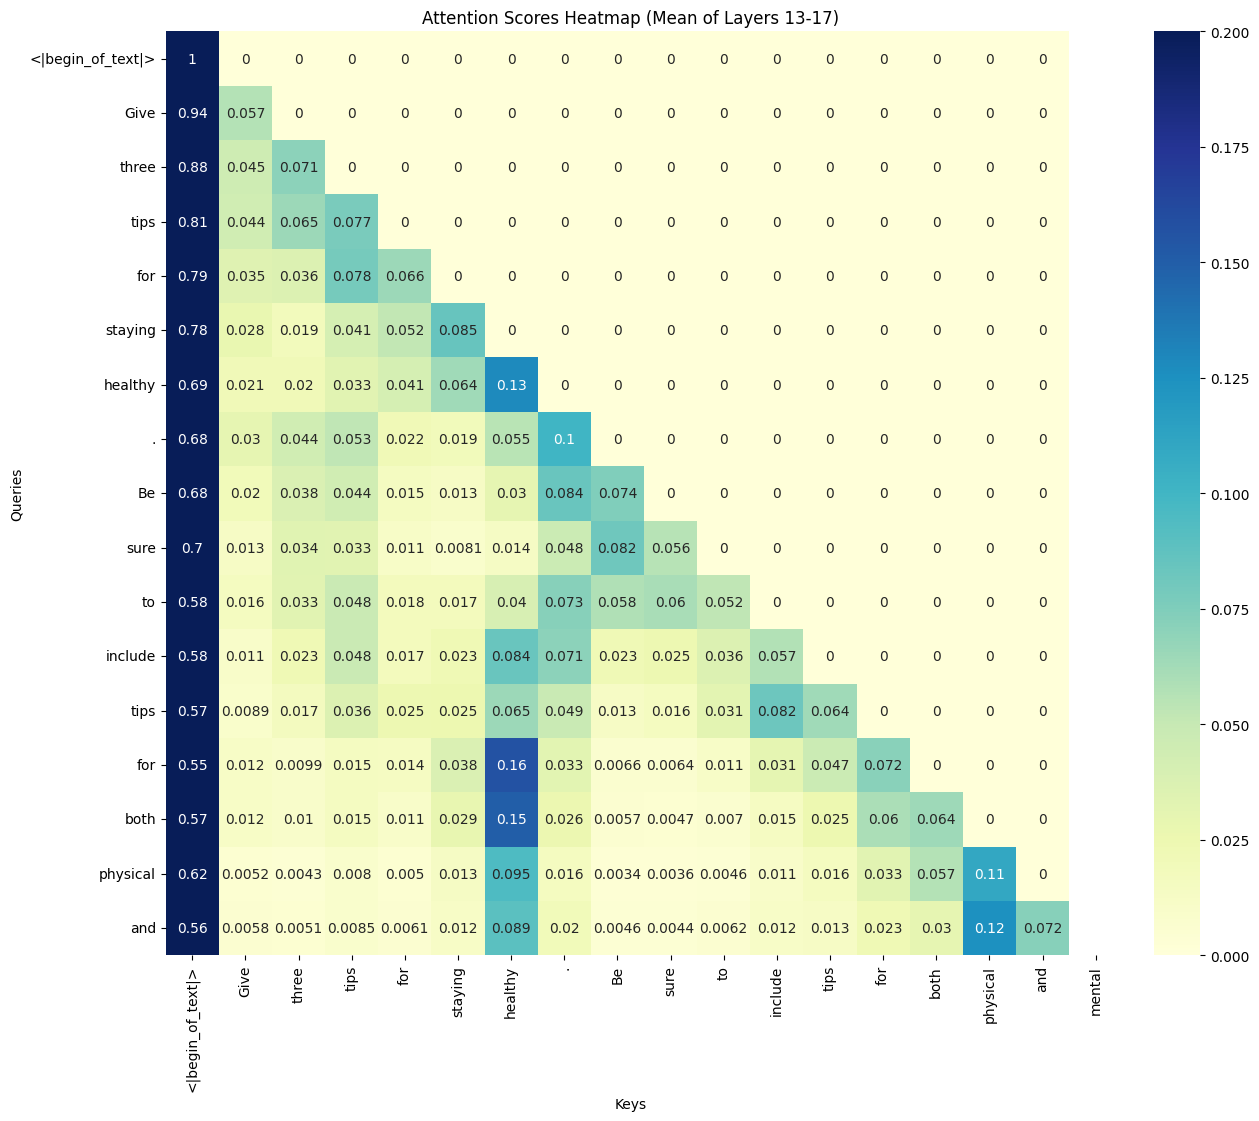

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import seaborn as sns
# 输入文本
input_text = "Give three tips for staying healthy."

# 将输入文本编码为 token
inputs = tokenizer(input_text, return_tensors="pt")

# 生成新 token
generate_output = model.generate(inputs['input_ids'], max_length=inputs['input_ids'].shape[1] + 10, output_attentions=True, return_dict_in_generate=True)

# 获取生成的所有 token 的注意力值
attentions = generate_output.attentions  # 这是一个包含所有生成步骤的注意力值的元组
generated_ids = generate_output.sequences[0]  # 获取生成的 token 序列

# 获取所有 token 标签
tokens = tokenizer.convert_ids_to_tokens(generated_ids)
tokens = [token.replace('Ġ', '') for token in tokens]

# 选择第 13 到第 17 层的索引
selected_layers = range(13, 17)  # Python 索引从 0 开始，第 13 层索引为 12，第 17 层索引为 16

# 初始化一个矩阵来存储所选层的注意力值的均值
all_attention = []
max_seq_length = max([step[0][0][0].shape[-1] for step in attentions])

for step in attentions:
    layer_attention = []
    for layer_index in selected_layers:
        attn = step[layer_index][0].detach().cpu().numpy()  # 形状 (num_heads, sequence_length, sequence_length)
        attn = attn.mean(axis=0)  # 对所有注意力头取均值，形状 (sequence_length, sequence_length)
        pad_width = max_seq_length - attn.shape[-1]
        if pad_width > 0:
            attn = np.pad(attn, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
        layer_attention.append(attn)
    # 对所选层的注意力值取均值
    mean_layer_attention = np.mean(layer_attention, axis=0)
    all_attention.append(mean_layer_attention)

# 将注意力值拼接成一个完整的矩阵
complete_attention_new = np.concatenate(all_attention, axis=0)

# 创建热力图
plt.figure(figsize=(15, 12))
sns.heatmap(complete_attention_new, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens[:complete_attention.shape[0]], vmin=0, vmax=0.2)
plt.title('Attention Scores Heatmap (Mean of Layers 13-17)')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()


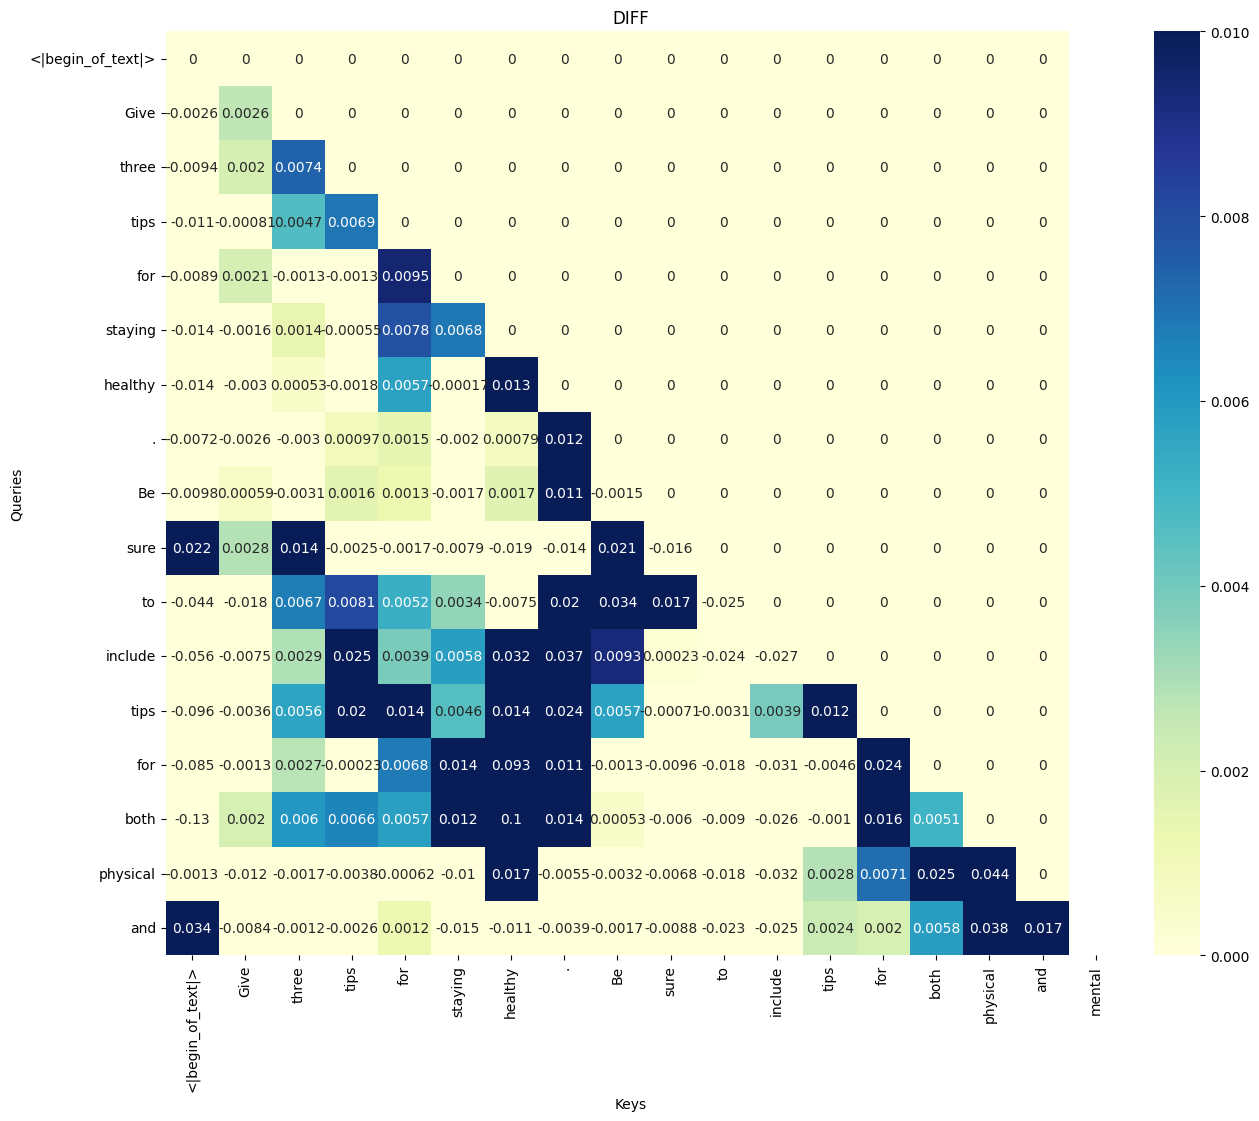

In [7]:
# 创建热力图
plt.figure(figsize=(15, 12))
sns.heatmap(complete_attention_new-complete_attention, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens[:complete_attention_new.shape[0]], vmin=0, vmax=0.01)
plt.title('DIFF')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()